# Lofi Gan V2

## About

This is similar to the original VERSION, but the main difference is that this will "continue" a song. The inputs to the generator will be 5 second song snippets, and the generator's goal is to come up with an appropriate 5 second continuation to that snippet. The discriminator will be fed those snippets as fakes and the 10 second snippet (the 5 second snippet fed to the generator and the 5 second snippet that actually came after it in the song) as truths. The generator may not be able to work with random noise (uses LSTM as first layer, and the random noise probably won't work), but should work perfectly fine with any 5 second LOFI snippet.

## Setup

In [1]:
import scipy.io.wavfile as wavfile
import tensorflow as tf
import numpy as np
import keras
import keras.layers as layers
import keras.models as models
import keras.losses as losses
import keras.optimizers as optimizers
import keras.regularizers as reg
import torch
import torchaudio  # for reducing sample rate

import os
import pickle
import random

import matplotlib.pyplot as plt
import time
from IPython import display


In [2]:
DEVICE = "GPU"

physical_devices = tf.config.list_physical_devices(DEVICE)
print(physical_devices)

print(tf.config.list_physical_devices())

print(torchaudio.get_audio_backend())


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
soundfile


In [3]:
VERSION = 4
BATCH_SIZE = 128
EPOCH_SIZE = BATCH_SIZE * 10
SHUFFLE_SIZE = 200
SONG_LEN_IN_SECONDS = 5

# our desired sample rate
SAMPLE_RATE = 12000
DATA_PREFIX = "D:/LofiData/"


## Get Ready To Load Data

Here, we load data stored on the wave file. Torchaudio converts it for us into a useful float32 mode even though it was originally in int16 (PCM) mode.

Here's the process that we'll be doing

In [4]:
file = DATA_PREFIX + "lofi-part1.wav"
print(torchaudio.info(file))
wavform, original_sample_rate = torchaudio.load(file)


AudioMetaData(sample_rate=48000, num_frames=304529272, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [5]:
print(wavform.shape, wavform.dtype)
print(wavform.max(), wavform.min())


torch.Size([1, 304529272]) torch.float32
tensor(0.9999) tensor(-1.)


In [6]:
total_seconds = wavform.shape[-1] / original_sample_rate
minutes = total_seconds // 60
seconds = total_seconds % 60
print(
    f"wave file of length {minutes} minutes and {seconds} seconds, which is {total_seconds} total seconds at sample rate {original_sample_rate}"
)


wave file of length 105.0 minutes and 44.35983333333297 seconds, which is 6344.359833333333 total seconds at sample rate 48000


In [7]:
# reduce sample rate
new_wavform = torchaudio.transforms.Resample(original_sample_rate, SAMPLE_RATE)(wavform)


In [8]:
# compare original vs downsampled
print(wavform[0, 0 : original_sample_rate * 10].shape)
print(new_wavform[0, 0 : SAMPLE_RATE * 10].shape)
display.display(
    display.Audio(wavform[0, 0 : original_sample_rate * 10], rate=original_sample_rate)
)
display.display(display.Audio(new_wavform[0, 0 : SAMPLE_RATE * 10], rate=SAMPLE_RATE))


torch.Size([480000])
torch.Size([120000])


The downsampled one sounds fuzzier but not too bad. So, now we perform that transform to all the data that we will be using.

## Load Data

In [9]:
# first, cleanup what we made just to save memory
del wavform
del new_wavform


Here's where we actually do it. We first select a random section of data. Then, we load that section.

In [10]:
total_song_len = 0
cumulative_song_lens = []

files = os.listdir(DATA_PREFIX)
for i in range(len(files)):
    file = files[i]
    metadata = torchaudio.info(DATA_PREFIX + file)
    song_len = metadata.num_frames // metadata.sample_rate * SAMPLE_RATE
    total_song_len += song_len
    cumulative_song_lens.append(total_song_len)

print(total_song_len)

start_section = random.randint(
    0, total_song_len - 2 * EPOCH_SIZE * SONG_LEN_IN_SECONDS * SAMPLE_RATE - 1
)
print(start_section)

idx = 0
while cumulative_song_lens[idx] < start_section:
    idx += 1

data = []


cur_idx = idx
while (
    cumulative_song_lens[cur_idx] - cumulative_song_lens[idx]
    < 2 * EPOCH_SIZE * SONG_LEN_IN_SECONDS * SAMPLE_RATE
):
    cur_idx += 1
    original_wav, original_sample_rate = torchaudio.load(DATA_PREFIX + files[cur_idx])
    data.append(
        torchaudio.transforms.Resample(original_sample_rate, SAMPLE_RATE)(
            original_wav
        ).numpy()
    )

print(len(data))


1148904000
861311990
3


In [11]:
# check to make sure we have enough samples
total = 0
for x in data:
    total += x.shape[-1]

print(total / (SONG_LEN_IN_SECONDS * SAMPLE_RATE))


2779.3099


## Prepare Dataset

Now that our data is in float32 mode, we move on to the next step. We turn the song data into 5 second song pairs for our dataset. 

In [12]:
pairs = []

# simulate diversity in dataset by starting the song sections at different times
# since that basically makes it a "new" observation
# and group into pairs while we're at it
for x in range(len(data)):
    start = random.randint(0, SONG_LEN_IN_SECONDS - 1)
    i = 0

    def transform(idx):
        # converts an index into the index in data
        return idx * SONG_LEN_IN_SECONDS * SAMPLE_RATE + start

    # add all songs to our list
    while transform(i * 2 + 1) < data[x].shape[-1] - SONG_LEN_IN_SECONDS * SAMPLE_RATE:
        pairs.append(
            [
                data[x][
                    0,
                    transform(i * 2) : transform(i * 2)
                    + SONG_LEN_IN_SECONDS * SAMPLE_RATE,
                ],
                data[x][
                    0,
                    transform(i * 2 + 1) : transform(i * 2 + 1)
                    + SONG_LEN_IN_SECONDS * SAMPLE_RATE,
                ],
            ]
        )
        i += 1
    print(i)

pairs = np.array(pairs)
pairs.shape


378
588
423


(1389, 2, 60000)

In [13]:
if pairs.shape[0] > EPOCH_SIZE:
    pairs = list(pairs)
    temp = []
    for i in range(EPOCH_SIZE):
        temp.append(pairs.pop(random.randint(0, len(pairs) - 1)))
    pairs = np.array(temp)

pairs.shape


(1280, 2, 60000)

In [14]:
# cleanup
del data


In [15]:
# check to make sure that it is still lofi and that they are pairs
song_to_play = random.choice(pairs)
display.Audio(list(song_to_play[0]) + list(song_to_play[1]), rate=SAMPLE_RATE)


In [16]:
# see if we can extract sections from pairs
pairs = tf.constant(pairs)
print(pairs.shape)

pairs[:, 0].shape


(1280, 2, 60000)


TensorShape([1280, 60000])

In [17]:
# make the dataset that the model will be trained on
dataset = (
    tf.data.Dataset.from_tensor_slices(pairs).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
)

# make sure that the shape is still (None, 2, SONG_LEN_IN_SECONDS*SAMPLE_RATE)
dataset


<BatchDataset element_spec=TensorSpec(shape=(None, 2, 60000), dtype=tf.float32, name=None)>

## Make Model

Here, we define our discriminator and generator models. The discriminator takes in two 5-second-long song snippets, turns them into one input, passes it through an LSTM, and then through hidden layers. The generator should also use an LSTM for processing the incoming 5-second-long song snippets, but it should then turn the LSTM outputs into a 5-second-long song. This means using some method of upscaling. In my case, I'm using Conv1DTransposes since making an LSTM or a Dense with as many nodes as there are samples in 5 seconds is entirely unfeasible for my GPU. 

In [18]:
# the shape of the noise to be transformed into LOFI
GENERATOR_INPUT_SIZE = (SAMPLE_RATE * SONG_LEN_IN_SECONDS,)

# fraction of a second that the LSTM should take as input
# ex: MULTIPLIER=2 means that the LSTM listens to sections 1/2 second long
MULTIPLIER = 16


In [19]:
def make_discriminator():
    model = models.Sequential()
    model.add(layers.Input((2, SONG_LEN_IN_SECONDS * SAMPLE_RATE)))
    model.add(
        layers.Reshape(
            (2 * SONG_LEN_IN_SECONDS * MULTIPLIER, SAMPLE_RATE // MULTIPLIER)
        )
    )

    model.add(layers.LSTM(1024, dropout=0.3, kernel_regularizer="l2"))

    model.add(layers.Dense(512, kernel_regularizer="l2"))
    model.add(layers.Dropout(0.3))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(256, kernel_regularizer="l2"))
    model.add(layers.Dropout(0.3))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(128, kernel_regularizer="l2"))
    model.add(layers.Dropout(0.3))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1))
    return model


In [20]:
discriminator = make_discriminator()


In [21]:
discriminator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 160, 750)          0         
                                                                 
 lstm (LSTM)                 (None, 1024)              7270400   
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [22]:
discriminator(
    tf.random.normal((1, 2, SONG_LEN_IN_SECONDS * SAMPLE_RATE)), training=False
)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.03483344]], dtype=float32)>

In [23]:
def make_generator():
    model = models.Sequential()
    model.add(layers.Input(GENERATOR_INPUT_SIZE))
    model.add(
        layers.Reshape((SONG_LEN_IN_SECONDS * MULTIPLIER, SAMPLE_RATE // MULTIPLIER))
    )

    model.add(layers.LSTM(600, dropout=0.3, activity_regularizer="l2"))
    print(model.output_shape)

    # kinda shape it into time sequences
    model.add(layers.Reshape((5, 120)))

    model.add(
        layers.Conv1DTranspose(
            240,
            8,
            strides=1,
            padding="same",
            activity_regularizer="l2",
            activation="elu",
        )
    )
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(
        layers.Conv1DTranspose(
            240,
            16,
            strides=2,
            padding="same",
            activity_regularizer="l2",
            activation="elu",
        )
    )
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.BatchNormalization())

    model.add(
        layers.Conv1DTranspose(
            240,
            16,
            strides=5,
            padding="same",
            activity_regularizer="l2",
            activation="elu",
        )
    )
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(
        layers.Conv1DTranspose(
            240,
            16,
            strides=5,
            padding="same",
            activity_regularizer="l2",
            activation="elu",
        )
    )
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.BatchNormalization())

    model.add(layers.Dense(240, activity_regularizer="l2", activation='tanh'))
    print(model.output_shape)

    model.add(layers.Flatten())
    print(model.output_shape)
    return model


In [24]:
generator = make_generator()


(None, 600)
(None, 5, 240)
(None, 10, 240)
(None, 50, 240)
(None, 250, 240)
(None, 250, 240)
(None, 60000)


In [25]:
generator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 80, 750)           0         
                                                                 
 lstm_1 (LSTM)               (None, 600)               3242400   
                                                                 
 reshape_2 (Reshape)         (None, 5, 120)            0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 5, 240)           230640    
 nspose)                                                         
                                                                 
 dropout_3 (Dropout)         (None, 5, 240)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 10, 240)          921840    
 ranspose)                                            

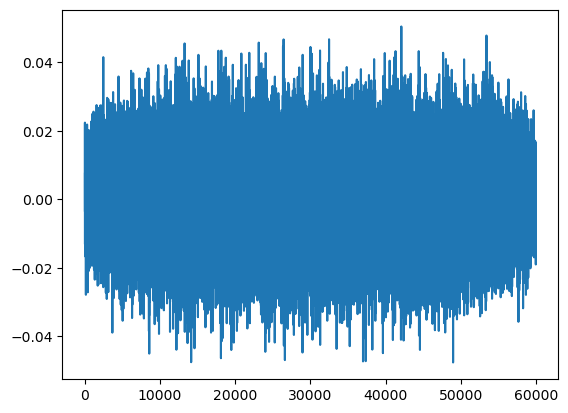

In [26]:
# check to make sure that we generate valid audio
output = generator(tf.random.normal((1, *GENERATOR_INPUT_SIZE)), training=False).numpy()
output = np.array(output, dtype=np.float32)
assert np.max(output) <= 1 and np.min(output) >= -1
display.display(display.Audio(output, rate=SAMPLE_RATE))
plt.plot(np.arange(0, output.shape[-1]), output[0])
plt.show()


## Loss and optimizers

These are standard GAN losses and practices.

In [27]:
with tf.device(DEVICE):
    loss = losses.BinaryCrossentropy(from_logits=True)
    generator_optimizer = optimizers.Adam(1e-4)
    discriminator_optimizer = optimizers.Adam(1e-4)


In [28]:
# loss functions
@tf.function
def generator_loss(fake_pred):
    # the generator's goal is to have all of its outputs
    # be classified as "real" by the discriminator
    return loss(tf.ones_like(fake_pred), fake_pred)


@tf.function
def discriminator_loss(true_pred, fake_pred):
    # the discriminator's goal is to have all of the real
    # inputs be classified as real and all the generated
    # inputs be classified as fake
    true_loss = loss(tf.ones_like(true_pred), true_pred)
    fake_loss = loss(tf.zeros_like(fake_pred), fake_pred)
    return true_loss + fake_loss


@tf.function
def discriminator_true_loss(true_pred):
    return loss(tf.ones_like(true_pred), true_pred)


@tf.function
def discriminator_fake_loss(fake_pred):
    return loss(tf.zeros_like(fake_pred), fake_pred)


## Training Loop

In [29]:
SAMPLES_TO_GENERATE = 4


def generate_and_save_audio(gen, epoch_num, display_output=True):
    # make the directory if it doesn't already exist
    if not os.path.exists(f"./generatedAudiov{VERSION}"):
        os.mkdir(f"./generatedAudiov{VERSION}")

    # get the inputs
    song_input = []
    for i in range(SAMPLES_TO_GENERATE):
        song_input.append(random.choice(pairs[random.randint(0, EPOCH_SIZE)].numpy()))
    song_input = np.array(song_input)
    print(song_input.shape)

    # run the generator
    inferences = generator(song_input, training=False).numpy()
    print(inferences.shape)

    # save and plot results
    figure, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    for i in range(len(inferences)):
        axs[i // 2, i % 2].plot(np.arange(0, inferences.shape[-1]), inferences[i])

        wavfile.write(
            f"./generatedAudiov{VERSION}/epoch_{epoch_num}_v{i}.wav",
            SAMPLE_RATE,
            inferences[i],
        )
        if display_output:
            display.display(
                display.Audio(f"./generatedAudiov{VERSION}/epoch_{epoch_num}_v{i}.wav")
            )
    figure.savefig(f"./generatedAudiov{VERSION}/epoch{epoch_num}_plots")
    plt.show()


In [30]:
# @tf.function  # with @tf.function performed slower than without. Maybe it's the tf.stack? Could also be the indexing
def train_generator_on_audio(audio):
    first_samples = audio[:, 0]
    second_samples = audio[:, 1]

    with tf.GradientTape() as gen_tape:
        # generate audio on actual audio
        generated_audio_1 = generator(first_samples, training=True)
        generated_audio_2 = generator(second_samples, training=True)

        # generate audio off itself
        generated_audio_3 = generator(generated_audio_1, training=True)
        generated_audio_4 = generator(generated_audio_2, training=True)

        # run discriminator
        fake_output_1 = discriminator(
            tf.stack([first_samples, generated_audio_1], axis=1), training=False
        )
        fake_output_2 = discriminator(
            tf.stack([second_samples, generated_audio_2], axis=1), training=False
        )

        fake_output_3 = discriminator(
            tf.stack([generated_audio_1, generated_audio_3], axis=1), training=False
        )
        fake_output_4 = discriminator(
            tf.stack([generated_audio_2, generated_audio_4], axis=1), training=False
        )

        # basic crossentropy loss
        gen_loss = (
            generator_loss(fake_output_1)
            + generator_loss(fake_output_2)
            + generator_loss(fake_output_3)
            + generator_loss(fake_output_4)
        )

        # add regularization loss
        gen_loss += tf.add_n(generator.losses)
        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )

def train_discriminator_on_audio(audio):
    # take pairs in each batch
    first_samples = audio[:, 0]
    second_samples = audio[:, 1]

    with tf.GradientTape() as disc_tape:
        # generate audio on actual audio
        generated_audio_1 = generator(first_samples, training=False)
        generated_audio_2 = generator(second_samples, training=False)

        # generate audio off itself
        generated_audio_3 = generator(generated_audio_1, training=False)
        generated_audio_4 = generator(generated_audio_2, training=False)

        # train discriminator
        true_output = discriminator(audio, training=True)

        fake_output_1 = discriminator(
            tf.stack([first_samples, generated_audio_1], axis=1), training=True
        )
        fake_output_2 = discriminator(
            tf.stack([second_samples, generated_audio_2], axis=1), training=True
        )

        fake_output_3 = discriminator(
            tf.stack([generated_audio_1, generated_audio_3], axis=1), training=True
        )
        fake_output_4 = discriminator(
            tf.stack([generated_audio_2, generated_audio_4], axis=1), training=True
        )

        # calculate crossentropy losses
        disc_loss = (
            discriminator_true_loss(true_output)
            + discriminator_fake_loss(fake_output_1)
            + discriminator_fake_loss(fake_output_2)
            + discriminator_fake_loss(fake_output_3)
            + discriminator_fake_loss(fake_output_4)
        )

        # add the regularizer losses
        disc_regularized_loss = tf.add_n(discriminator.losses)
        disc_loss += disc_regularized_loss

    # calculate gradients
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    # apply gradients
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )



# @tf.function  # with @tf.function performed slower than without. Maybe it's the tf.stack? Could also be the indexing
def train_step_on_audio(audio):
    # take pairs in each batch
    first_samples = audio[:, 0]
    second_samples = audio[:, 1]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate audio on actual audio
        generated_audio_1 = generator(first_samples, training=True)
        generated_audio_2 = generator(second_samples, training=True)

        # generate audio off itself
        generated_audio_3 = generator(generated_audio_1, training=True)
        generated_audio_4 = generator(generated_audio_2, training=True)

        # train discriminator
        true_output = discriminator(audio, training=True)

        fake_output_1 = discriminator(
            tf.stack([first_samples, generated_audio_1], axis=1), training=True
        )
        fake_output_2 = discriminator(
            tf.stack([second_samples, generated_audio_2], axis=1), training=True
        )

        fake_output_3 = discriminator(
            tf.stack([generated_audio_1, generated_audio_3], axis=1), training=True
        )
        fake_output_4 = discriminator(
            tf.stack([generated_audio_2, generated_audio_4], axis=1), training=True
        )

        # calculate crossentropy losses
        gen_loss = (
            generator_loss(fake_output_1)
            + generator_loss(fake_output_2)
            + generator_loss(fake_output_3)
            + generator_loss(fake_output_4)
        )
        disc_loss = (
            discriminator_true_loss(true_output)
            + discriminator_fake_loss(fake_output_1)
            + discriminator_fake_loss(fake_output_2)
            + discriminator_fake_loss(fake_output_3)
            + discriminator_fake_loss(fake_output_4)
        )

        # add the regularizer losses
        gen_regularized_loss = tf.add_n(generator.losses)
        disc_regularized_loss = tf.add_n(discriminator.losses)
        gen_loss += gen_regularized_loss
        disc_loss += disc_regularized_loss

    # calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    # apply gradients
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss, gen_regularized_loss, disc_regularized_loss


# not used in training, but idea is there
def train_step_on_noise():
    noise = tf.random.normal((BATCH_SIZE, *GENERATOR_INPUT_SIZE))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_audio_1 = generator(noise, training=True)
        generated_audio_2 = generator(generated_audio_1, training=True)

        fake_output = discriminator(
            tf.stack([generated_audio_1, generated_audio_2], axis=1), training=True
        )

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_fake_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss


In [31]:
SOLO_GEN_TIMES = 0
SOLO_DISC_TIMES= 2
epoch_name = f"epoch_v{VERSION}.b"
category_name = "reduced_sr"
training_name = "regularized_loss_audio"


def train(
    dataset,
    epochs: int,
    save_model_every: int = 3,
    save_output_every: int = 1,
    display_output: bool = True,
    tf_logdir: str = "",
):
    # tensorboard logs
    summary_writer = None
    if tf_logdir != "":
        summary_writer = tf.summary.create_file_writer(tf_logdir)

    # get epoch
    if os.path.exists(epoch_name):
        with open(epoch_name, "rb") as file:
            epoch = pickle.load(file)["epoch"]
    else:
        epoch = 0
        with open(epoch_name, "wb") as file:
            pickle.dump({"epoch": epoch}, file)

    # train for the amount of epochs
    for i in range(epochs):
        epoch += 1
        start = time.time()

        gen_loss_audio, disc_loss_audio = 0, 0
        gen_loss_regularized, disc_loss_regularized = 0, 0
        num_batches = 0

        for audio_batch in dataset:
            # train generator a couple times so it doesn't fall behind
            for x in range(SOLO_GEN_TIMES):
                train_generator_on_audio(audio_batch)
            for x in range(SOLO_DISC_TIMES):
                train_discriminator_on_audio(audio_batch)

            # train both
            losses = train_step_on_audio(audio_batch)
            gen_loss_audio += losses[0]
            disc_loss_audio += losses[1]
            gen_loss_regularized += losses[2]
            disc_loss_regularized += losses[3]

            num_batches += 1

        # take the average of the losses
        gen_loss_audio /= num_batches
        disc_loss_audio /= num_batches
        gen_loss_regularized /= num_batches
        disc_loss_regularized /= num_batches

        # record the progress if a logdir was provided
        if summary_writer is not None:
            with summary_writer.as_default():
                tf.summary.scalar(
                    f"{category_name}/generator_{training_name}", gen_loss_audio, epoch
                )
                tf.summary.scalar(
                    f"{category_name}/discriminator_{training_name}",
                    disc_loss_audio,
                    epoch,
                )

                # the losses purely from the regularized weights
                tf.summary.scalar(
                    f"{category_name}/generator_regularization_loss",
                    gen_loss_regularized,
                    epoch,
                )
                tf.summary.scalar(
                    f"{category_name}/discriminator_regularization_loss",
                    disc_loss_regularized,
                    epoch,
                )

                # the losses purely from the discriminator and generator
                tf.summary.scalar(
                    f"{category_name}/generator_plain_loss",
                    gen_loss_audio - gen_loss_regularized,
                    epoch,
                )
                tf.summary.scalar(
                    f"{category_name}/discriminator_plain_loss",
                    disc_loss_audio - disc_loss_regularized,
                    epoch,
                )

        display.clear_output(wait=True)

        # Produce audio every `save_output_every` epochs
        if (i + 1) % save_output_every == 0:
            generate_and_save_audio(generator, epoch, display_output)

        # Save the model every `save_model_every` epochs
        if (i + 1) % save_model_every == 0:
            generator.save(f"./generatorv{VERSION}Continued")
            discriminator.save(f"./discriminatorv{VERSION}Continued")

        print(
            "Time for epoch {} (# {} of this session) is {} sec".format(
                epoch, i + 1, time.time() - start
            )
        )

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_audio(generator, epoch)

    # save our epoch number
    with open(epoch_name, "wb") as file:
        pickle.dump({"epoch": epoch}, file)


## Save and Load

In [32]:
def save(generator_path, discriminator_path):
    generator.save(f"{generator_path}")
    discriminator.save(f"{discriminator_path}")


def load(generator_path, discriminator_path):
    generator.load_weights(f"{generator_path}")
    discriminator.load_weights(f"{discriminator_path}")


In [33]:
load(f"./generatorv{VERSION}/", f"./discriminatorv{VERSION}/")


## Train

Finally, after all of that setup, we train. This is the time-consuming part. A wild guess is that it will take about a week to train.

(4, 60000)
(4, 60000)


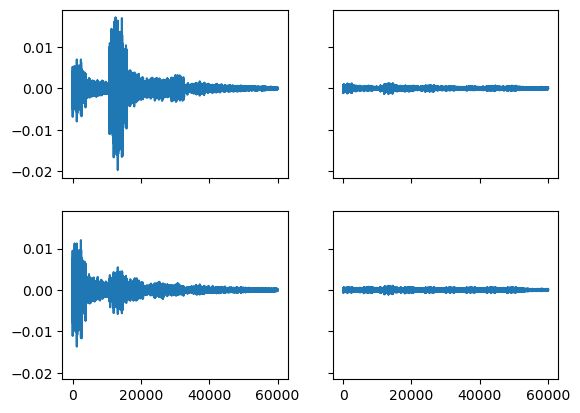

In [34]:
with tf.device(DEVICE):
    train(dataset, 200, save_model_every=100, save_output_every=10, tf_logdir="logs")


In [35]:
save(f"./generatorv{VERSION}/", f"./discriminatorv{VERSION}/")


INFO:tensorflow:Assets written to: ./generatorv4/assets


INFO:tensorflow:Assets written to: ./generatorv4/assets


INFO:tensorflow:Assets written to: ./discriminatorv4/assets


INFO:tensorflow:Assets written to: ./discriminatorv4/assets


## Visualize

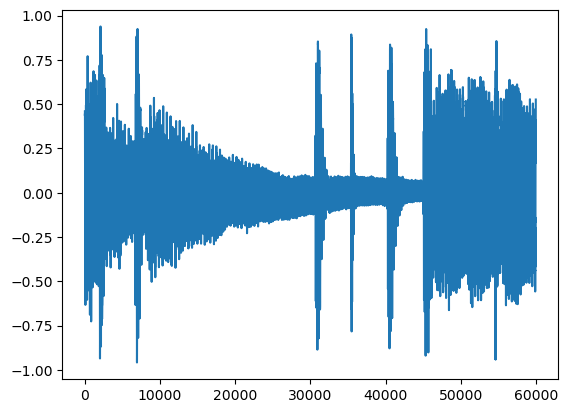

In [36]:
# "what it should look sorta like"
song_choice = random.choice(pairs[random.randint(0, EPOCH_SIZE - 1)].numpy())
plt.plot(np.arange(0, SAMPLE_RATE * SONG_LEN_IN_SECONDS), song_choice)
display.display(display.Audio(song_choice, rate=SAMPLE_RATE))
plt.show()


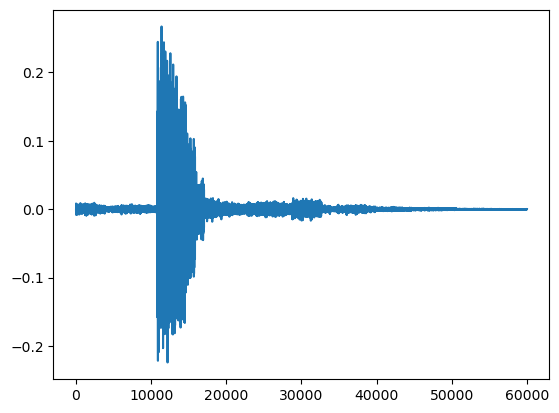

In [37]:
# "what it actually looks like" 
# same as what is shown in every generate_and_save_audio plot
song_choice = np.array([random.choice(pairs[random.randint(0, EPOCH_SIZE - 1)].numpy())])
output = generator(
    song_choice,
    training=False,
).numpy()[0]
plt.plot(np.arange(0, SAMPLE_RATE * SONG_LEN_IN_SECONDS), output)
display.display(display.Audio(output, rate=SAMPLE_RATE))
plt.show()


In [38]:
discriminator(np.stack([song_choice, [output]], axis=1), training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.3874911]], dtype=float32)>

In [39]:
discriminator(np.array([random.choice(pairs)]), training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.3874911]], dtype=float32)>